In [412]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy as sp

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [299]:
nH = 1e-9
fF = 1e-15
GHz = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [366]:
n_eig  = 5
n_plot = 20
param_name = '\\Delta'
param_values = np.geomspace(1e-4, 1e1, n_plot)
Δ_values = param_values

labels_low = ['(0,0)','(1,0)','(0,1)','(1,1)']
labels_high = ['(0,2)','(2,0)','(0,3)','(1,2)','(2,1)','(3,0)','(0,4)','(1,3)','(2,2)','(3,1)','(4,0)']


In [385]:
C, CJ, Csh, Lq, Lr, _, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
# EJ*=1.2
# CJ*=0.9
# Lq*=1.1
φ_ext=0.5

In [394]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_minus_ω_r = [] 
g_r_limit=np.zeros(len(Δ_values))
g_fq_limit=np.zeros(len(Δ_values))
g_xx_pert = np.zeros(len(Δ_values))
g_zz_pert = np.zeros(len(Δ_values))
g_yy_pert = np.zeros(len(Δ_values))

for i, Δ in enumerate(Δ_values):
    C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ)
    
    H_0, H   = sq_ext.hamiltonian_qubit(Lq=L_F_eff, Lr=Lr, fluxonium = fluxonium, resonator = resonator, Δ=Δ, return_H_0=True)
    
    Hf = fluxonium.hamiltonian()
    Hr = resonator.hamiltonian()
    
    ψ0_f         = sq_ext.diag(Hf, n_eig=5, solver='numpy', real=True)[1]
    ψ0_r         = sq_ext.diag(Hr, n_eig=5, solver='numpy', real=True)[1]
    
    ψ_0_low = [ qt.tensor(qt.Qobj(ψ0_f[:,0]), qt.Qobj(ψ0_r[:,0])), 
                qt.tensor(qt.Qobj(ψ0_f[:,1]), qt.Qobj(ψ0_r[:,0])),
                qt.tensor(qt.Qobj(ψ0_f[:,0]), qt.Qobj(ψ0_r[:,1])), 
                qt.tensor(qt.Qobj(ψ0_f[:,1]), qt.Qobj(ψ0_r[:,1])) ]
    
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0_low, H=H, real=True, remove_ground=True)

    ψ_0_high = [ qt.tensor(qt.Qobj(ψ0_f[:,0]), qt.Qobj(ψ0_r[:,2])), 
                 qt.tensor(qt.Qobj(ψ0_f[:,2]), qt.Qobj(ψ0_r[:,0])),
                 qt.tensor(qt.Qobj(ψ0_f[:,0]), qt.Qobj(ψ0_r[:,3])),
                 qt.tensor(qt.Qobj(ψ0_f[:,1]), qt.Qobj(ψ0_r[:,2])),
                 qt.tensor(qt.Qobj(ψ0_f[:,2]), qt.Qobj(ψ0_r[:,1])),
                 qt.tensor(qt.Qobj(ψ0_f[:,3]), qt.Qobj(ψ0_r[:,0])),
                 qt.tensor(qt.Qobj(ψ0_f[:,0]), qt.Qobj(ψ0_r[:,4])),
                 qt.tensor(qt.Qobj(ψ0_f[:,1]), qt.Qobj(ψ0_r[:,3])),
                 qt.tensor(qt.Qobj(ψ0_f[:,2]), qt.Qobj(ψ0_r[:,2])),
                 qt.tensor(qt.Qobj(ψ0_f[:,3]), qt.Qobj(ψ0_r[:,1])), 
                 qt.tensor(qt.Qobj(ψ0_f[:,4]), qt.Qobj(ψ0_r[:,0])) ]
        
    # ψ_0_high = [ψ_0_high[i] for i in [3,4,8]]
    V = H-H_0
    
    E_0_ψ_0_low  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_low]
    E_0_ψ_0_high = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_high]

    H_eff_p2, H_eff_p2_decomposed  =  sq_ext.H_eff_p2_decomposed(ψ_0_low, ψ_0_high, E_0_ψ_0_low, E_0_ψ_0_high, V,  remove_ground=True)

    E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0_low)+2, out='GHz', solver='scipy')[0]
    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0_low)+2, out='GHz', solver='Qutip', qObj=True)
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low,E_0)
    ψ_low = ψ[subspace_indices]
    E_low = E[subspace_indices]
    
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0_low, ψ_low, E_low, remove_ground=True)
    
    Pauli_p1.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p1, print_pretty=False))
    Pauli_p2.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p2, print_pretty=False))
    Pauli_SWT.append(sq_ext.decomposition_in_pauli_4x4  (H_eff_SWT, print_pretty=False))
    
    fluxonium.diag(3);
    resonator.diag(3);
    omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    omega_r  = resonator.efreqs[1]-resonator.efreqs[0]
    
    ω_f_minus_ω_r.append(omega_r-omega_f)
    
    # Analytic estimation of coupling
    E_L_f = sq_ext.L_to_EL(L_F_eff)
    V_fluxonium =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V_fluxonium).x
    
    Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt((L_F_eff * nH)/(C_F_eff * fF)))
    Φ_r_01 = np.sqrt(0.5*np.sqrt((L_R_eff * nH)/(C_R_eff * fF)))
    
    g_fq_limit[i] = 1/(L_C_eff * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] =  1/(L_C_eff * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz

    
    Φ_f = fluxonium.flux_op(0, basis='eig')
    Φ_r = resonator.flux_op(0, basis='eig')
    g_xx_pert[i] = 1 / L_C_eff  *  Φ_f[0,1]*Φ_r[0,1] / 2 / np.pi
    g_zz_pert[i] =   ( (1 / L_C_eff )**2   * ( 
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(omega_f+omega_r) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(omega_f+omega_r) +
                   -Φ_r[1,2]**2 * Φ_f[1,2]**2/(omega_f+omega_r) +
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(omega_f-omega_r) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(omega_r-omega_f2)  
                     )/ 2 / np.pi /4 / 6 )
    
Pauli_p1 = np.array(Pauli_p1)
Pauli_p1 = Pauli_p1- Pauli_p1[0,:]

Pauli_p2 = np.array(Pauli_p2)
Pauli_p2 = Pauli_p2- Pauli_p2[0,:]

Pauli_SWT = np.array(Pauli_SWT)
Pauli_SWT = Pauli_SWT- Pauli_SWT[0,:]

ω_f_minus_ω_r = np.array(ω_f_minus_ω_r)

C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1872: ComplexWarning: Casting complex values to real discards the imaginary part
  rd= number of decimals to use when rounding a number.
C:\Users\gabri\AppData\Local\Temp\ipykernel_3960\2797439284.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  g_xx_pert[i] = 1 / L_C_eff  *  Φ_f[0,1]*Φ_r[0,1] / 2 / np.pi
C:\Users\gabri\AppData\Local\Temp\ipykernel_3960\2797439284.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  g_zz_pert[i] =   ( (1 / L_C_eff )**2   * (


C:\Users\gabri\AppData\Local\Temp\ipykernel_3960\1593887500.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(Δ_values, g_xx_pert , '*', color = colors[0], marker='o', markersize='4')
C:\Users\gabri\AppData\Local\Temp\ipykernel_3960\1593887500.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(Δ_values, g_zz_pert , '*', color = colors[2], marker='o', markersize='4')


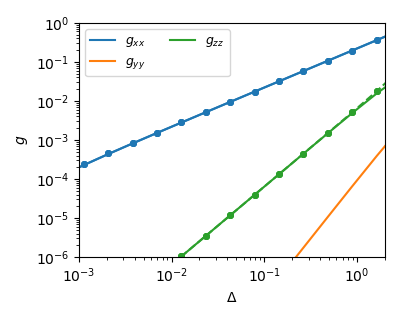

In [395]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=100)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True
for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    # if i==0 or i==1:
    #     continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(Δ_values, σxσx, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(Δ_values, σyσy, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(Δ_values, σzσz, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')
    # ax1.plot(Δ_values, ω_f_minus_ω_r/10 , color = colors[3], linestyle=linestyles[i], label = r'$(\omega_+-\omega_-)/10$')

    # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'g_{xx}, fluxon', markersize='2')
    # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'g_{xx}, plasmon', markersize='2')
    ax1.plot(Δ_values, g_xx_pert , '*', color = colors[0], marker='o', markersize='4')
    ax1.plot(Δ_values, g_zz_pert , '*', color = colors[2], marker='o', markersize='4')
    # ax1.plot(Δ_values, g_yy_pert , '*', color = colors[1],  markersize='4')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-6,1e0])
ax1.set_xlim([1e-3,2])
ax1.set_ylabel('$g$')
ax1.set_xlabel('$\Delta$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
figs.export('g_H_eff_vs_Delta.pdf', fig)
fig.show()

In [396]:
g_zz_pert/σzσz

C:\Users\gabri\AppData\Local\Temp\ipykernel_3960\3099414922.py:1: RuntimeWarning: divide by zero encountered in divide
  g_zz_pert/σzσz


array([inf, 1.432597651753, 1.103933731999, 1.033341276471, 1.014049261897, 1.008441440771, 1.006786612691, 1.006296628120, 1.006156118707, 1.006131515637, 1.006182245168, 1.006392337376, 1.007110045289, 1.009525250680, 1.017644931554, 1.044984940513, 1.137992829080, 1.478514571816, 3.623616493813,
       0.174322228388])

C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


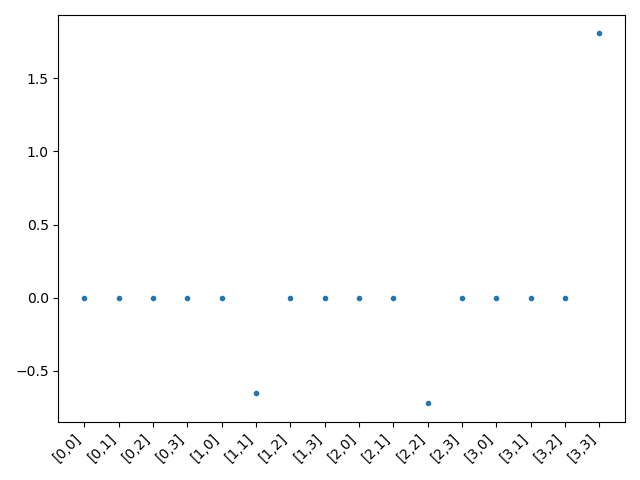

In [397]:
labels = [f"[{i},{j}]" for i in range(4) for j in range(4)]

fig, ax = plt.subplots()

ax.plot(H_eff_p2.flatten(), '.')

ax.set_xticks(ticks=range(4*4), labels=labels, rotation=45, ha="right")
fig.tight_layout()
fig.show()

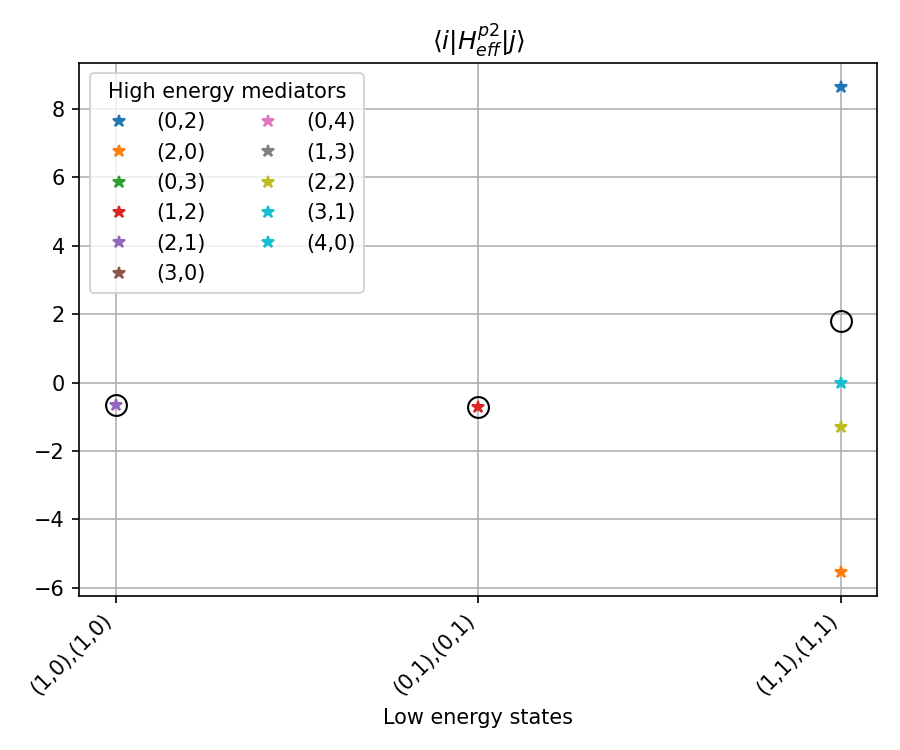

In [421]:
importlib.reload(sq_ext)

sq_ext.plot_second_order_contributions(H_eff_p2, H_eff_p2_decomposed, labels_low, labels_high,figsize=np.array([6, 5]) * 1 ,threshold =1e-4)